# Project 3 - Tennis: Collaboration and Competition

* Implement a multi-agent DDPG algorithm to train two agents to play a game of tennis

## 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.20 which is incompatible.


## 2. Load the necessary libraries and software modules

In [2]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
from collections import namedtuple, deque
import sys
sys.path.insert(0, '/home/workspace/python/src/')

## 3. Load 'Tennis' Unity Environment
The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [3]:
from unityagents import UnityEnvironment
env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 4. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for both agents look like:', states)

rewards = env_info.rewards
print('The rewards for both agents look like:', rewards)

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for both agents look like: [[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.65278625 -1.5        -0.          0.
   6.83172083  6.         -0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.         -6.4669857  -1.5         0.          0.
  -6.83172083  6.          0.          0.        ]]
The rewards for both agents look like: [0.0, 0.0]


## 5. Global Hyperparameters

In [6]:
# Seed the RNG for reproducability
SEED = 1

# Select GPU for training if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 6. Class Definitions
* Define various classes directly in the notebook for editing convenience
* Found that updating logic in external python files was not getting immediately reflected in this notebook

### 6.1 Action Space Noise and Replay Buffer
* Implement action space noise via an Ornstein-Uhlenbeck process for policy exploration
* Create a buffer to store experience tuples and sample uncorrelated batches

In [7]:
class OUNoise:
    def __init__(self, size, mu=0., theta=0.15, sigma=0.2):
        """Initialize noise parameters"""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(SEED)
        self.reset()
        
    def reset(self):
        """Reset the internal state to mean."""
        self.state = copy.copy(self.mu)
        
    def sample(self):
        """Update internal state and return it as a noise sample"""
        x =self.state
        noise = self.theta * (self.mu - x) + self.sigma * (np.random.randn(*x.shape)-0.5)
        self.state = self.theta + noise
        return self.state

    
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object."""
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(SEED)
        
    def add(self, state, action, reward, next_state, done):
        """Store new experience to replay memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        """Randomly sample a batch of experiences from memory for training"""
        experiences =  random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """"Return the current size of internal memory"""
        return len(self.memory)

### 6.2 Define Actor and Critic Network Architecture
* DDPG utilizes an Actor/Critic network architecture to estimate the optimal policy/value functions
* Adapted from Pendulum model in the Udacity Deep Reinforcement Learning Github repo

In [8]:

UNIFORM_BOUND = 5e-3     # bounds for uniform distribution 

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1.0/np.sqrt(fan_in)
    return (-lim,lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""
    
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model."""
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()
    
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-UNIFORM_BOUND, UNIFORM_BOUND)
        
    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.bn2(self.fc2(x)))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):
    """Critic (Value) Model."""
    
    def __init__(self, state_size, action_size, fc1_units=256, fc2_units=256):
        """Initialize parameters and build model."""
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(SEED)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-UNIFORM_BOUND, UNIFORM_BOUND)
        
    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 6.3 Define DDPG Agent

In [9]:
### Hyperparameters
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 10        # learning timestep interval
NUM_LEARNS = 5         # number of learning passes
UPDATE_EVERY = 1        # update timestep interval
NUM_UPDATES = 1         # number of updates each interval
NOISE_VAR = 1.0         # amplitude of action space noise
NOISE_REDUCTION = 1e-5  # reduction rate of action noise

class DDPG_Agent():   
    def __init__(self, state_size, action_size, num_agents=2):
        """Initialize a DDPG Agent object."""
        self.seed = random.seed(SEED)
        self.epsilon = NOISE_VAR
        
        # Initialize the local and target Actor network
        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        # Initialize the local and target Critic network
        self.critic_local = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC)
        
        # Initialize the Replay memory
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)
        
        # Initialize the Ornsten-Uhlenbeck process to add exploration noise
        self.noise = OUNoise((num_agents,action_size))
        
        
    def reset(self):
        self.noise.reset()
        
        
    def step(self, S, A, R, NS, T, t_i):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.memory.add(S, A, R, NS, T)

        # Learn at specified interval, if enough samples are available in memory
        # -> option to learn multiple times per interval
        if len(self.memory) > BATCH_SIZE and t_i % LEARN_EVERY == 0:
            for _ in range(NUM_LEARNS):
                experiences = self.memory.sample()
                self.learn(experiences, t_i)
                
        if NOISE_REDUCTION > 0:
            self.epsilon -= NOISE_REDUCTION
                
                
    def act(self, S, explore=True):
        """Returns actions for given state as per current policy."""
        S = torch.from_numpy(S).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(S).cpu().data.numpy()
        self.actor_local.train()
        if explore:
            action += self.epsilon * self.noise.sample()    
        return np.clip(action, -1, 1)
    
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target_model = TAU*θ_local_model + (1 - TAU)*θ_target_model
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)
        
        
    def learn(self, experiences, t_i):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
        """
        S, A, R, NS, T = experiences
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        NA = self.actor_target(NS)
        Q_targets_next = self.critic_target(NS, NA)
        
        # compute Q-value targets
        Q_targets = R + (GAMMA * Q_targets_next * (1 - T))
        
        # compute critic loss
        Q_expected = self.critic_local(S, A)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # compute actor loss
        A_pred = self.actor_local(S)
        actor_loss = -self.critic_local(S, A_pred).mean()
        
        # minimize actor loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # ----------------------- update target networks ----------------------- #
        if (t_i % UPDATE_EVERY == 0):
            for _ in range(NUM_UPDATES):
                self.soft_update(self.critic_local, self.critic_target, TAU)
                self.soft_update(self.actor_local, self.actor_target, TAU)


## 7. Initialize DDPG Agent Object
* Show internal network architecture

In [10]:
agent = DDPG_Agent(state_size, action_size) # instantiate the DDPG agent
print(agent.actor_local)
print(agent.critic_local)

Actor(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)
Critic(
  (fc1): Linear(in_features=24, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=258, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)


## 8. Define Training Loop
* Specify constraints for agent training:
    * Max episodes
    * Max episode timesteps
    * finish line score

In [11]:
PASSING_SCORE = 0.5      # environment solved when average score over 100 episodes is this value 

def train(n_episodes=2000, max_t=1000, print_every=50):
    
    max_scores = [] 
    avg_scores = [] 
    scores_deque = deque(maxlen=100) # project requires average over 100 episodes

    # iterate over episodes
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        scores = np.zeros(num_agents)
        
        # iterate over timesteps each episode
        for t in range(max_t):
            actions = agent.act(states, explore=True)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            scores += rewards
            
            # iterate over agents in environment
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)
                
            states = next_states
            if np.any(dones):
                break

        # Bookkeep scores each episode
        max_scores.append(np.max(scores))
        scores_deque.append(np.max(scores)) 
        avg_scores.append(np.mean(scores_deque))
        
        # print progress
        print('\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.2f}'.format(i_episode, avg_scores[-1], max_scores[-1]), end="")
        
        # latch print at specified interval
        if i_episode % print_every == 0:
            print("\rEpisode {}\tAverage Score: {:.4f}\tMax Score: {:.2f}".format(i_episode, avg_scores[-1], max_scores[-1]))

        # record final data once completion targets reached (Average 'PASSING_SCORE' for 100 consecutive episodes)
        if avg_scores[-1] >= PASSING_SCORE and i_episode >= 100:
            print("\nEnvironment solved in {} episodes.\tAverage score: {:.4f}".format(i_episode, avg_scores[-1]))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_final.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_final.pth')
            break    
            
    return max_scores, avg_scores


## 9. Train Agent and Plot Performance

Episode 50	Average Score: 0.0020	Max Score: 0.00
Episode 100	Average Score: 0.0048	Max Score: 0.09
Episode 150	Average Score: 0.0066	Max Score: 0.00
Episode 200	Average Score: 0.0028	Max Score: 0.00
Episode 250	Average Score: 0.0000	Max Score: 0.00
Episode 300	Average Score: 0.0010	Max Score: 0.00
Episode 350	Average Score: 0.0090	Max Score: 0.00
Episode 400	Average Score: 0.0166	Max Score: 0.00
Episode 450	Average Score: 0.0096	Max Score: 0.10
Episode 500	Average Score: 0.0125	Max Score: 0.00
Episode 550	Average Score: 0.0336	Max Score: 0.10
Episode 600	Average Score: 0.0366	Max Score: 0.00
Episode 650	Average Score: 0.0379	Max Score: 0.00
Episode 700	Average Score: 0.0697	Max Score: 0.30
Episode 750	Average Score: 0.2126	Max Score: 0.10
Episode 800	Average Score: 0.2842	Max Score: 0.30
Episode 850	Average Score: 0.4802	Max Score: 0.20
Episode 851	Average Score: 0.5052	Max Score: 2.60
Environment solved in 851 episodes.	Average score: 0.5052


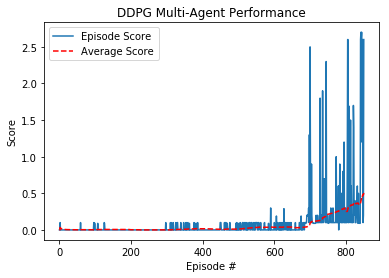

In [12]:
from workspace_utils import active_session # prevent notebook connection from dropping during long training session
import matplotlib.pyplot as plt
%matplotlib inline

MAX_EPISODES = 2000      # maximum number of training episodes
MAX_TIMESTEPS = 1000     # maximum number of timesteps per episode

with active_session():
    episode_scores, average_scores = train(MAX_EPISODES, MAX_TIMESTEPS)
    
    fig = plt.figure()
    plt.plot(np.arange(len(episode_scores)), episode_scores, label='Episode Score ')
    plt.plot(np.arange(len(episode_scores)), average_scores, c='r', linestyle = '--', label='Average Score')
    plt.title('DDPG Multi-Agent Performance')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend()
    plt.show()

## 10. Future Work for Performance Improvements

Ideas for improved performance:
* Implement parameter space noise rather than action space noise to ensure network output actions are not independent of input states
* Use a prioritized replay buffer rather than sampling experience tuples according to a uniform distribution
* Perform more testing to understand why there appears to be a high sensitivity to network/agent implementation methodology (like defining classes in .py files as opposed to here in the notebook. See attached Report.md) and take steps to mitigate
* Instead of only using fully connected (linear) layers, try incorporating more complex nodes like LSTM cells to better capture temporal relationships
* Test with other features like leaky_relu activation functions and dropout layers to see how they impact performance 
